Setup Packages and Functions
===

In [1]:
from pystan import StanModel
# import stanity
n_jobs = 4
import pandas as pd
import seaborn as sns
sns.set_color_codes()
import pickle
%pylab inline
from scipy.stats import norm, truncnorm, multivariate_normal, lognorm, t

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pystan.misc import _summary, _array_to_table
def _print_stanfit(fit, pars=None, probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=2):
        if fit.mode == 1:
            return "Stan model '{}' is of mode 'test_grad';\n"\
                   "sampling is not conducted.".format(fit.model_name)
        elif fit.mode == 2:
            return "Stan model '{}' does not contain samples.".format(fit.model_name)
        if pars is None:
            pars = fit.sim['pars_oi']
            fnames = fit.sim['fnames_oi']

        n_kept = [s - w for s, w in zip(fit.sim['n_save'], fit.sim['warmup2'])]
        header = ""#Inference for Stan model: {}.\n".format(fit.model_name)
        header += "{} chains, each with iter={}; warmup={}; thin={}; \n"
        header = header.format(fit.sim['chains'], fit.sim['iter'], fit.sim['warmup'],
                               fit.sim['thin'], sum(n_kept))
        header += "post-warmup draws per chain={}, total post-warmup draws={}.\n\n"
        header = header.format(n_kept[0], sum(n_kept))
        footer = "\n\nSamples were drawn using {} at {}.\n"\
#             "For each parameter, n_eff is a crude measure of effective sample size,\n"\
#             "and Rhat is the potential scale reduction factor on split chains (at \n"\
#             "convergence, Rhat=1)."
        sampler = fit.sim['samples'][0]['args']['sampler_t']
        date = fit.date.strftime('%c')  # %c is locale's representation
        footer = footer.format(sampler, date)
        s = _summary(fit, pars, probs)
        body = _array_to_table(s['summary'], s['summary_rownames'],
                               s['summary_colnames'], digits_summary)
        return header + body + footer
    
def plot_time_series_inference(model_fit, var='Y_sim', x=None,
                               ax=None, ind=0, **kwargs):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 75, 97.5]
    if len(model_fit[var].shape)<3:
        data = model_fit[var]
    else:
        data = model_fit[var][:,:,ind]
    CIs = scoreatpercentile(data, ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(data.shape[1])
    ax.fill_between(x, CIs[2.5], CIs[97.5],alpha=.5, **kwargs)
    ax.fill_between(x, CIs[25], CIs[75], **kwargs)
    
from scipy.stats import percentileofscore
def portion_of_data_within_CI(model_fit, parameter, data, lower=2.5, upper=97.5):
    if data.ndim<2:
        a = array((list(map(percentileofscore, model_fit[parameter].T, data))))
        return mean((lower<a)*(a<upper))
    else:
        values = empty(data.shape[1])
        for i in range(data.shape[1]):
            a = array((list(map(percentileofscore, model_fit[parameter][:,i], data.iloc[:,i]))))
            values[i]=nanmean((lower<a)*(a<upper))
        return values
    
def portion_of_forecast_within_CI(model_fit, forecast, data, 
                                  forecast_start_ind, forecast_stop_ind,
                                  lower=2.5, upper=97.5):
    u = percentile(model_fit[forecast],upper,axis=0)
    l = percentile(model_fit[forecast],lower,axis=0)
    return nanmean((l[forecast_start_ind:forecast_stop_ind]<data[forecast_start_ind:forecast_stop_ind])*
                   (data[forecast_start_ind:forecast_stop_ind]<u[forecast_start_ind:forecast_stop_ind]),
                  axis=0)

def calculate_Omega_from_L_Omega(model_fit):
    f = lambda x,y: matrix(x)*matrix(y)
    return list(map(f, model_fit['L_Omega'], transpose(model_fit['L_Omega'],[0,2,1])))

def calculate_covariance_from_L_Omega_and_tau(model_fit):
    Omegas = calculate_Omega_from_L_Omega(model_fit)
    f = lambda tau, Omega: diag(tau)*Omega*diag(tau)
    return list(map(f, model_fit['tau'], Omegas))

Define Time Series Models and Ensure They Correctly Fit to Simulated Data
===

Define a basic Stan program that will handle multiple time series and missing data. (missing entries coded as below -900).

This basic program will be filled in with code for specific models.

In [3]:
base_time_series_program="""
functions{
    %(functions)s
}

data {
    int N_technologies;
    int N_updates;
    vector[N_updates] observed_updates;
    int updates_tech_inds[N_updates];
    
    int tech_starts[N_technologies];
    int tech_stops[N_technologies];
    
    real first_observation_value[N_technologies];
    int first_observation[N_technologies];
    int last_observation[N_technologies];  
    int backcast_to_observation;
    int forecast_to_observation;
    
    
    int N_gaps;
    real gap_heights[N_gaps];
    int gap_lengths[N_gaps];
    
    int N_gap_updates;

    %(priors)s
}

  
parameters {
    vector%(update_raw_bounds)s[N_gap_updates] gap_updates_raw; // inferred updates between first and last observations

    %(parameters)s    
}

transformed parameters {
    //vector[N_time_steps_to_fit] Y_latent; // value each time period
    vector%(update_bounds)s[N_gap_updates] gap_updates;
    vector%(update_bounds)s[N_updates] updates;
    
    {
    int latest_gap_position;
    latest_gap_position = 1;
    for(i in 1:N_gaps){
        gap_updates[latest_gap_position:latest_gap_position+gap_lengths[i]] = 
        gap_updates_raw[latest_gap_position:latest_gap_position+gap_lengths[i]]/
        sum(gap_updates_raw[latest_gap_position:latest_gap_position+gap_lengths[i]]) 
        * gap_heights[i];
        latest_gap_position = latest_gap_position + gap_lengths[i] + 1;
    }
    }
    
    {
    int gap_ind;
    gap_ind = 1;
    for (u in 1:N_updates){
        if (observed_updates[u]!=-999.0){
            updates[u] = observed_updates[u];
        }
        else{
            updates[u] = gap_updates[gap_ind];
            gap_ind = gap_ind + 1;
        }
        
    }
    }
}

model {
    %(model)s
}

generated quantities {

    matrix[forecast_to_observation,N_technologies] Y_sim;
    
    {
    int updates_ind;
    updates_ind = 1;
    for (tech in 1:N_technologies){
        Y_sim[first_observation[tech], tech] = first_observation_value[tech];
        Y_sim[first_observation[tech]+1:
              first_observation[tech]+1+tech_stops[tech]-tech_starts[tech],
              tech] = cumulative_sum(updates[tech_starts[tech]:tech_stops[tech]]) 
                      + rep_vector(first_observation_value[tech], tech_stops[tech]-tech_starts[tech]+1);
    }
    }

    {
    real update_size;
    //Fill out future data points
    for (tech in 1:N_technologies){
        for(t in last_observation[tech]+1:forecast_to_observation){
            %(update_size)s
            Y_sim[t, tech] = update_size + Y_sim[t-1, tech];
        }
    }
    }

    //Fill out past data points
    {
    int t;
    real update_size;
    for (tech in 1:N_technologies){
        t = first_observation[tech];
        while(t>backcast_to_observation){
            %(update_size)s
            Y_sim[t-1, tech] = Y_sim[t, tech] - update_size;
            t = t-1;
        }
    }
    }
}
"""

Define a Python helper function that will take time series data and generate the variables to pass to the Stan program.

In [4]:
def stan_data_from_Y(Y,
                     backcast_to_observation=1,
                    forecast_to_observation=156):
    Y = Y.copy()
    Y.index = arange(Y.shape[0])
    Y.columns = arange(Y.shape[1])
    N_time_periods, N_technologies = Y.shape
    first_observation = Y.apply(lambda x: x.first_valid_index())
    last_observation = Y.apply(lambda x: x.last_valid_index())
    first_observation_value = Y.apply(lambda x: x[x.first_valid_index()])

    N_updates = sum(last_observation-first_observation)
    
#     Y_vector = []
    updates_vector = []
    tech_starts = []
    tech_stops = []
    updates_tech_inds = []
    for i in Y.columns:
        tech_starts.append(len(updates_vector))
        this_updates = Y.ix[first_observation[i]:last_observation[i],i].diff()[1:].values.tolist()
        updates_vector += this_updates
        tech_stops.append(len(updates_vector))
        updates_tech_inds+=[i for j in this_updates]
    updates_vector = pd.Series(updates_vector)
#     N_time_steps_to_fit = len(Y_vector)
    N_updates = len(updates_vector)

#     Y_vector_gap_time_steps = Y_vector[Y_vector.isnull()].index.values

    # N_preceding_time_periods = first_observation
    # N_proceding_time_periods = N_time_periods-last_observation-1
    N_gap_updates = {}#zeros(N_technologies).astype('int')
#     N_gaps = zeros(N_technologies).astype('int')
    gap_starts = {}
    gap_stops = {}
    gap_lengths = {}
    gap_heights = {}
    gap_time_steps = {}
    gap_techs = {}
    for i in Y.columns:
        gap_inds = Y.ix[first_observation[i]:last_observation[i],i].isnull().astype('int')
        d = gap_inds.diff()
        gap_starts[i] = d[d==1].index.values.astype('int')
        gap_stops[i] = d[d==-1].index.values.astype('int')
        gap_lengths[i] = gap_stops[i]-gap_starts[i]
        N_gap_updates[i] = gap_lengths[i]+1
#         N_gaps[i] = len(gap_starts[i])
        gap_heights[i] = Y.ix[gap_stops[i],i].values - Y.ix[gap_starts[i]-1,i].values
        gap_time_steps[i] = gap_inds[gap_inds==1].index.values
#         gap_techs[i] = i*ones(N_gap_time_steps[i])

    gap_heights_vector = []
    gap_lengths_vector = []
    # gap_time_steps_vector = []
    # gap_techs_vector = []
    for i in Y.columns:
        gap_heights_vector+=gap_heights[i].tolist()
        gap_lengths_vector+=gap_lengths[i].tolist()
    #     gap_time_steps_vector+=gap_time_steps[i].tolist()
    #     gap_techs_vector+=gap_techs[i].tolist()

    stan_data = {'N_technologies': N_technologies,
                 'N_updates': N_updates,
                 'observed_updates': updates_vector.fillna(-999.0),
                 'updates_tech_inds': array(updates_tech_inds).astype('int')+1,
#                 'N_time_steps_to_fit': N_time_steps_to_fit,
                 'tech_starts': array(tech_starts).astype('int')+1,
                 'tech_stops': array(tech_stops).astype('int'),
                 'N_gaps': len(gap_heights_vector),
                 'gap_heights': gap_heights_vector,
                 'gap_lengths': array(gap_lengths_vector).astype('int'),
                 'N_gap_updates': sum([sum(N_gap_updates[i]) for i in N_gap_updates]),
#                  'Y_gap_time_steps': Y_vector_gap_time_steps+1,
                'first_observation_value': first_observation_value,                 
                'first_observation': first_observation.astype('int')+1,
                'last_observation': last_observation.astype('int')+1,
                'backcast_to_observation': backcast_to_observation,
                'forecast_to_observation': forecast_to_observation}
    
    return stan_data

Define specific time series models, which will plug into the basic time series program
====

In [5]:
models = {}

Montonic Models
----

### Normal (Truncated)

In [10]:
model_name = 'improvement~N(mu,sigma)'
models[model_name] = {}
models[model_name]['code'] = base_time_series_program%{

### model
'model': """
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

    target += lower_truncated_normal_lpdf_vector(updates, mu[updates_tech_inds], sigma[updates_tech_inds], 0.0);
""",

### parameters
'parameters': """
    vector<lower = 0>[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;
""",
    
#### priors
'priors':"""
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
""",

### increase size
'update_size': """
    // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
    // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
    update_size = -1.0;  
    while (update_size<0){
        update_size = normal_rng(mu[tech],sigma[tech]);
    }
""",

### functions
'functions':"""
    real lower_truncated_normal_lpdf_vector(vector x, vector mu, vector sigma, real A) {
            return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
    }
""",
    
### update bounds (Dictates if updates can only be positive, only negative, or both. Give the empty string for both.)
'update_bounds':"""<lower = 0>""",
'update_raw_bounds':"""<lower = 0, upper = 1>""",
}

models[model_name]['model_parameters'] = ['mu', 'sigma']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 3,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d39d2c2b9184ddb55d9d0d7cd0dc3e8a NOW.


In [11]:
model_name = 'improvement~N(mu,sigma), hierarchical'
models[model_name] = {}
models[model_name]['code'] = base_time_series_program%{

### model
'model': """
    tau ~ cauchy(0, 2);
    L_Omega ~ lkj_corr_cholesky(1);
    mu_mu ~ normal(mu_prior_location, mu_prior_scale);
    mu_sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

    {
    matrix[N_technologies, 2] parvec;
    vector[2] mu_parvec;

    parvec = append_col(mu, sigma);
    mu_parvec[1] = mu_mu;
    mu_parvec[2] = mu_sigma;
    for (tech in 1:N_technologies){
        log(parvec[tech]) ~ multi_normal_cholesky(log(mu_parvec), diag_pre_multiply(tau, L_Omega));
    }
    }
    
    target += lower_truncated_normal_lpdf_vector(updates, mu[updates_tech_inds], sigma[updates_tech_inds], 0.0);
""",
    
### parameters
'parameters': """
    vector<lower = 0>[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;

    cholesky_factor_corr[2] L_Omega;
    vector<lower = 0>[2] tau;

    real<lower = 0> mu_mu;
    real<lower = 0> mu_sigma;
""",
    
#### priors
'priors':"""
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
""",

### increase size
'update_size': """
    // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
    // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
    update_size = -1.0;  
    while (update_size<0){
        update_size = normal_rng(mu[tech],sigma[tech]);
    }
""",

### functions
'functions':"""
    real lower_truncated_normal_lpdf_vector(vector x, vector mu, vector sigma, real A) {
            return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
    }
""",

### update bounds (either 0 or 1. Dictates if updates can only be positive, only negative, or both)
'update_bounds':"""<lower = 0>""",
'update_raw_bounds':"""<lower = 0, upper = 1>""",

}

models[model_name]['model_parameters'] = ['mu', 'sigma']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 3,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96c3fbc956adf2778841451895006af5 NOW.


Simulate time series and fit them with models

In [34]:
### Random walk, missing data, positive steps, multiple technologies, mu and sigma are correlated across technologies
mu_mu = .3
mu_sigma = .5

Omega = matrix([[1,.7],
               [.7,1]])
tau = array([1,1])
cov = diag(tau)*Omega*diag(tau)

p_missing = 0.3
n = 100
N_technologies = 50

mus = zeros(N_technologies)
sigmas = zeros(N_technologies)

simulated_time_series = empty((n, N_technologies))
for i in arange(N_technologies):
    while mus[i]==0:
        mu, sigma = multivariate_normal(array([mu_mu, mu_sigma]), cov=cov).rvs(1)
        if mu>0 and sigma>0:
            mus[i] = mu
            sigmas[i] = sigma
    a = -mu / sigma
    simulated_data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
    simulated_time_series[:,i] = cumsum(simulated_data)
    missing = rand(n)<p_missing
    simulated_time_series[missing,i]=nan
    
stan_data = stan_data_from_Y(pd.DataFrame(simulated_time_series),forecast_to_observation=110)

Portion of true mus within 95% credible interval: 0.96
Portion of true sigmas within 95% credible interval: 0.86
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        0.8  6.2e-3   0.29   0.14   0.61   0.84   1.02   1.24   2189    1.0
mu[1]       0.65  5.2e-4   0.03   0.59   0.63   0.65   0.67   0.71   4000    1.0
mu[2]       1.19  9.3e-4   0.06   1.07   1.15   1.19   1.23    1.3   4000    1.0
mu[3]       0.96  2.5e-3   0.13   0.65   0.89   0.97   1.04   1.16   2617    1.0
mu[4]       0.64  9.6e-4   0.06    0.5   0.61   0.65   0.68   0.74   4000    1.0
mu[5]       0.92  6.8e-3   0.36   0.16   0.69   0.96   1.19   1.51   2747    1.0
mu[6]       0.99  9.5e-3   0.46    0.1   0.64   1.02   1.34   1.77   2340    1.0
mu[7]       0.99  9.7e-3   0.51   0.08    0.6    1.0   1.38   1.93   2799    1.0
mu[8]       1.47  4.8e-3    0.2   0.95  

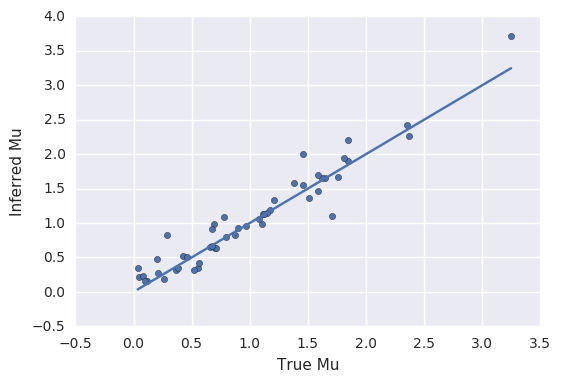

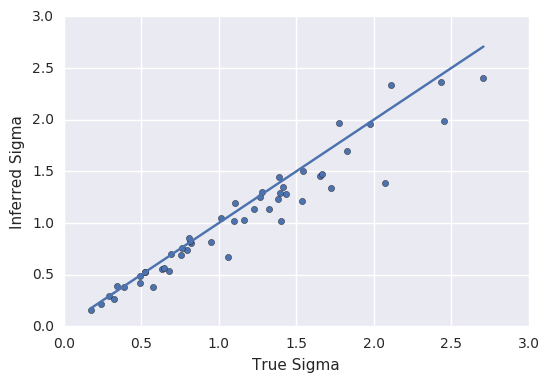

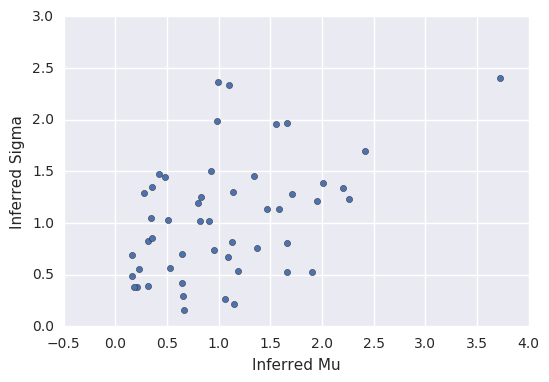

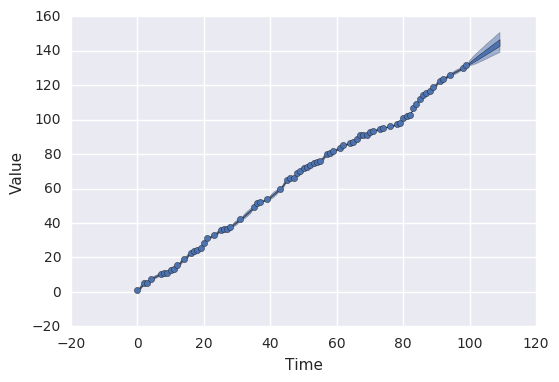

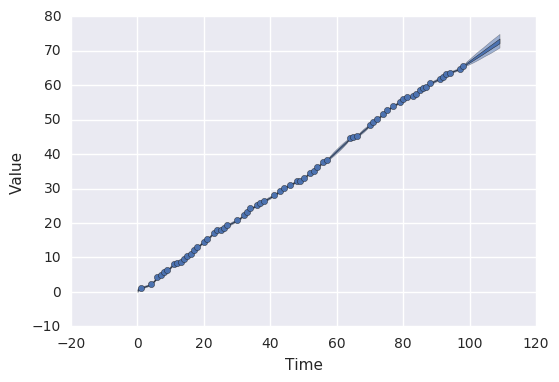

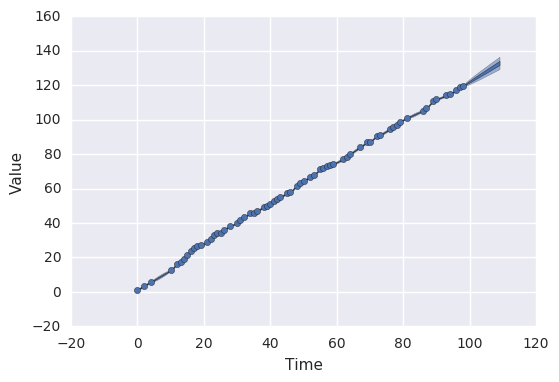

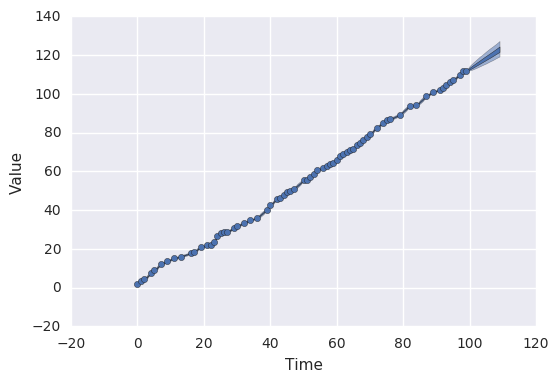

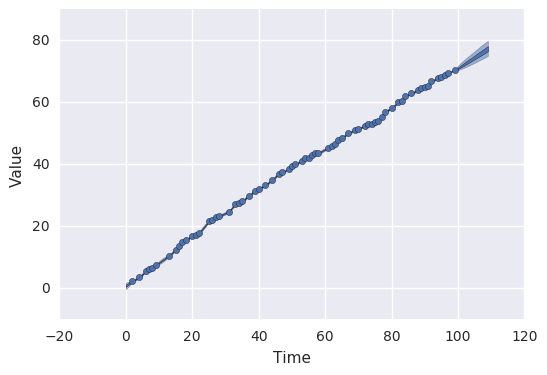

In [35]:
model_name = 'improvement~N(mu,sigma)'
model_fit = models[model_name]['stan_model'].sampling(data={**stan_data, 
                                                            **models[model_name]['parameter_priors']}, 
                                                      n_jobs=n_jobs)

print("Portion of true mus within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print("Portion of true sigmas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))

print(_print_stanfit(model_fit, ['mu', 'sigma']))


scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
plot(sort(mus),sort(mus))
xlabel("True Mu")
ylabel("Inferred Mu")

figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
plot(sort(sigmas),sort(sigmas))
xlabel("True Sigma")
ylabel("Inferred Sigma")

figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )
xlabel("Inferred Mu")
ylabel("Inferred Sigma")

    
for i in arange(stan_data['N_technologies'])[:5]:
    figure()
    plot_time_series_inference(model_fit,'Y_sim',ind=i)
    scatter(arange(simulated_time_series.shape[0]),
               simulated_time_series[:,i])
    xlabel("Time")
    ylabel("Value")

Portion of true mus within 95% credible interval: 0.80
Portion of true sigmas within 95% credible interval: 0.74
Inferred Omega:
[[ 1.          0.46911802]
 [ 0.46911802  1.        ]]
Inferred Tau:
[ 0.67964433  0.65674908]
Inferred Covariance
[[ 0.46847488  0.21207814]
 [ 0.21207814  0.43637015]]
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.91  4.5e-3    0.2   0.47   0.78   0.93   1.05   1.26   1924    1.0
mu[1]       0.65  5.5e-4   0.03   0.58   0.63   0.65   0.67   0.71   4000    1.0
mu[2]       1.18  9.6e-4   0.06   1.05   1.14   1.18   1.22   1.29   4000    1.0
mu[3]       0.95  2.8e-3   0.12   0.69   0.89   0.97   1.04   1.14   1785    1.0
mu[4]       0.64  1.3e-3   0.06    0.5   0.61   0.65   0.68   0.74   2173    1.0
mu[5]       1.07  5.9e-3   0.26   0.53    0.9   1.09   1.25   1.52   1862    1.0
mu[6]       1.26

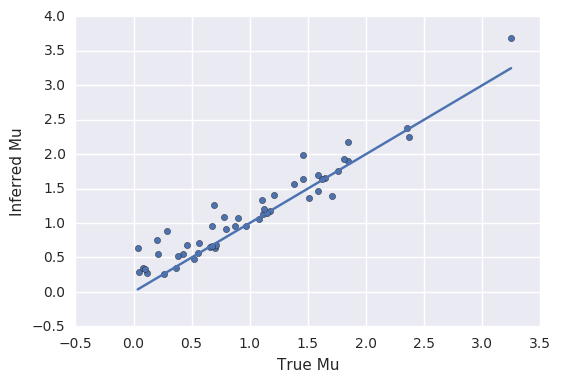

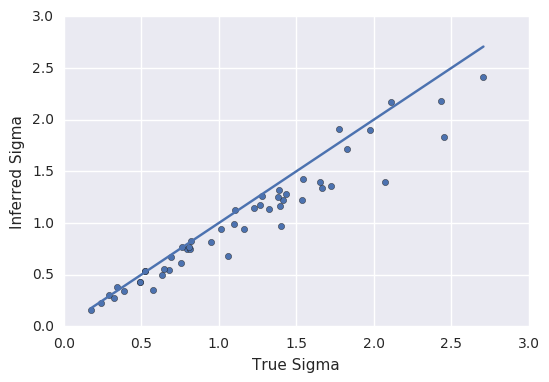

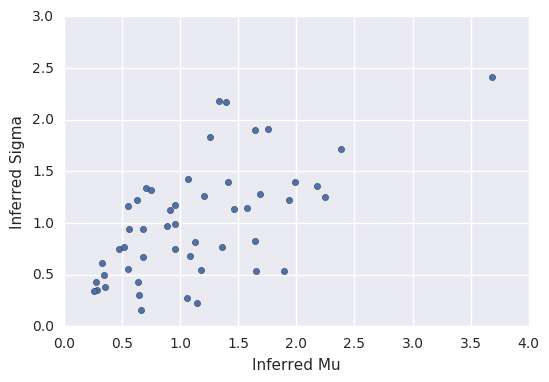

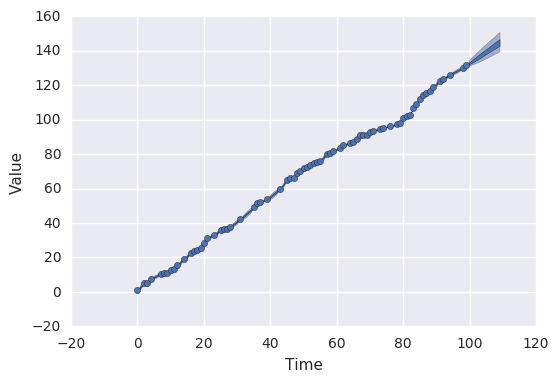

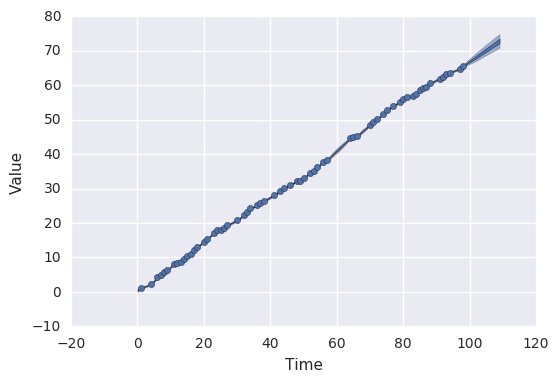

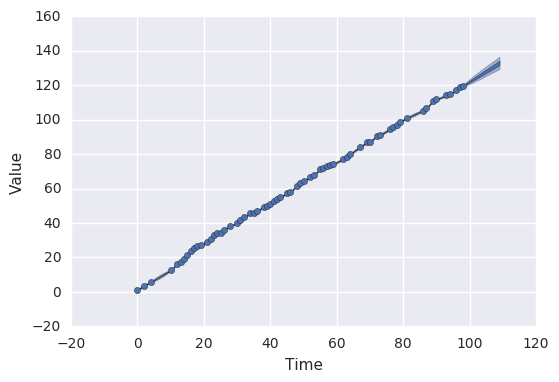

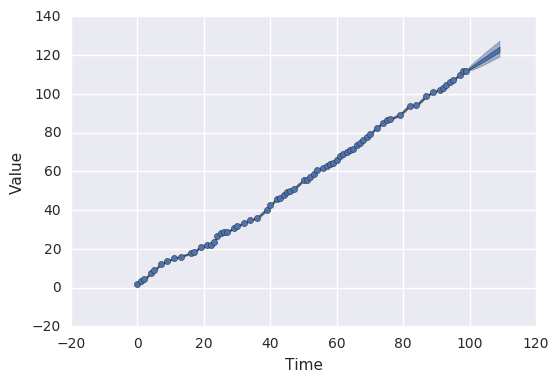

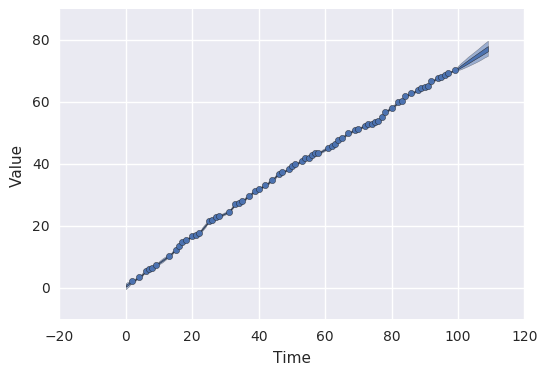

In [36]:
model_name = 'improvement~N(mu,sigma), hierarchical'
model_fit = models[model_name]['stan_model'].sampling(data={**stan_data, 
                                                            **models[model_name]['parameter_priors']}, 
                                                      n_jobs=n_jobs)

print("Portion of true mus within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print("Portion of true sigmas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))

print("Inferred Omega:")
print(mean(calculate_Omega_from_L_Omega(model_fit),axis=0))

print("Inferred Tau:")
print(model_fit['tau'].mean(axis=0))


print("Inferred Covariance")
print(mean(calculate_covariance_from_L_Omega_and_tau(model_fit),axis=0))

print(_print_stanfit(model_fit, ['mu', 'sigma']))


scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
plot(sort(mus),sort(mus))
xlabel("True Mu")
ylabel("Inferred Mu")

figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
plot(sort(sigmas),sort(sigmas))
xlabel("True Sigma")
ylabel("Inferred Sigma")

figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )
xlabel("Inferred Mu")
ylabel("Inferred Sigma")

    
for i in arange(stan_data['N_technologies'])[:5]:
    figure()
    plot_time_series_inference(model_fit,'Y_sim',ind=i)
    scatter(arange(simulated_time_series.shape[0]),
               simulated_time_series[:,i])
    xlabel("Time")
    ylabel("Value")

### Lognormal

In [12]:
model_name = 'improvement~logN(mu,sigma)'
models[model_name] = {}
models[model_name]['code'] = base_time_series_program%{
### model
'model': """
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

    target += lognormal_lpdf(updates | mu[updates_tech_inds], sigma[updates_tech_inds]);
""",

### parameters
'parameters': """
    vector[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;
""",
    
#### priors
'priors':"""
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
""",

### increase size
'update_size': """
    update_size = lognormal_rng(mu[tech],sigma[tech]);
""",

### functions
'functions':"""

""",
    
### update bounds (either 0 or 1. Dictates if updates can only be positive, only negative, or both)
'update_bounds':"""<lower = 0>""",
'update_raw_bounds':"""<lower = 0, upper = 1>""",
}

models[model_name]['model_parameters'] = ['mu', 'sigma']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 1,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 3,
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_13519188d68bebaeddecf0a7266d175a NOW.


In [13]:
model_name = 'improvement~logN(mu,sigma), hierarchical'
models[model_name] = {}
models[model_name]['code'] = base_time_series_program%{
### model
'model': """
    tau ~ cauchy(0, 2);
    L_Omega ~ lkj_corr_cholesky(1);
    mu_mu ~ normal(mu_prior_location, mu_prior_scale);
    mu_sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

    {
    matrix[N_technologies, 2] parvec;
    vector[2] mu_parvec;

    parvec = append_col(mu, log(sigma));
    mu_parvec[1] = mu_mu;
    mu_parvec[2] = log(mu_sigma);
    for (tech in 1:N_technologies){
        parvec[tech] ~ multi_normal_cholesky(mu_parvec, diag_pre_multiply(tau, L_Omega));
    }
    }
    
    target += lognormal_lpdf(updates | mu[updates_tech_inds], sigma[updates_tech_inds]);
""",
    
### parameters
'parameters': """
    vector[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;

    cholesky_factor_corr[2] L_Omega;
    vector<lower = 0>[2] tau;

    real mu_mu;
    real<lower = 0> mu_sigma;
""",
    
#### priors
'priors':"""
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
""",

### increase size
'update_size': """
    update_size = lognormal_rng(mu[tech],sigma[tech]);
""",

### functions
'functions':"""

""",
### update bounds (either 0 or 1. Dictates if updates can only be positive, only negative, or both)
'update_bounds':"""<lower = 0>""",
'update_raw_bounds':"""<lower = 0, upper = 1>""",
    
}

models[model_name]['model_parameters'] = ['mu', 'sigma']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 3,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_18f9fa9aa4cd34fd0433c707d112e99a NOW.


In [39]:
### Random walk, missing data, positive steps, multiple technologies, mu and sigma are correlated across technologies
mu_mu = .3
mu_sigma = .5

Omega = matrix([[1,.7],
               [.7,1]])
tau = array([1,1])
cov = diag(tau)*Omega*diag(tau)

p_missing = 0.3
n = 100
N_technologies = 50

mus = zeros(N_technologies)
sigmas = zeros(N_technologies)

simulated_time_series = empty((n, N_technologies))
for i in arange(N_technologies):
    while mus[i]==0:
        mu, sigma = multivariate_normal(array([mu_mu, mu_sigma]), cov=cov).rvs(1)
        if sigma>0:
            mus[i] = mu
            sigmas[i] = sigma
    simulated_data = lognorm(sigma, scale=exp(mu), loc=0).rvs(n)
    simulated_time_series[:,i] = cumsum(simulated_data)
    missing = rand(n)<p_missing
    simulated_time_series[missing,i]=nan
    
stan_data = stan_data_from_Y(pd.DataFrame(simulated_time_series))

Portion of true mus within 95% credible interval: 0.92
Portion of true sigmas within 95% credible interval: 0.94
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        0.6  3.3e-4   0.02   0.56   0.59    0.6   0.61   0.64   4000    1.0
mu[1]       1.14  4.9e-5 3.1e-3   1.14   1.14   1.14   1.14   1.15   4000    1.0
mu[2]        0.5  2.2e-3   0.14   0.22   0.41    0.5   0.59   0.78   4000    1.0
mu[3]      -0.56  3.0e-4   0.02   -0.6  -0.57  -0.56  -0.55  -0.52   4000    1.0
mu[4]       2.07  2.9e-3   0.18   1.71   1.95   2.07   2.19   2.42   4000    1.0
mu[5]       0.91  3.1e-3   0.19   0.53   0.79   0.91   1.04    1.3   4000    1.0
mu[6]       0.36  4.7e-4   0.03    0.3   0.34   0.36   0.38   0.42   4000    1.0
mu[7]       0.93  9.6e-4   0.06   0.81   0.89   0.93   0.97   1.05   4000    1.0
mu[8]       1.06  1.4e-3   0.09   0.88  

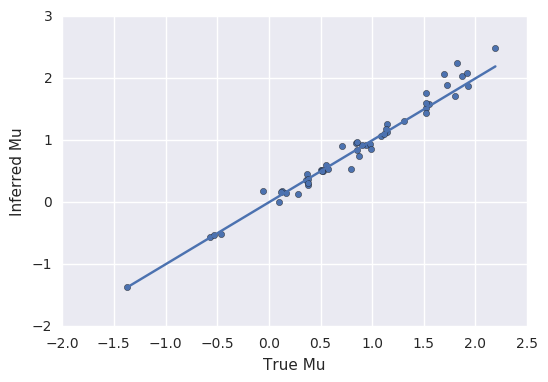

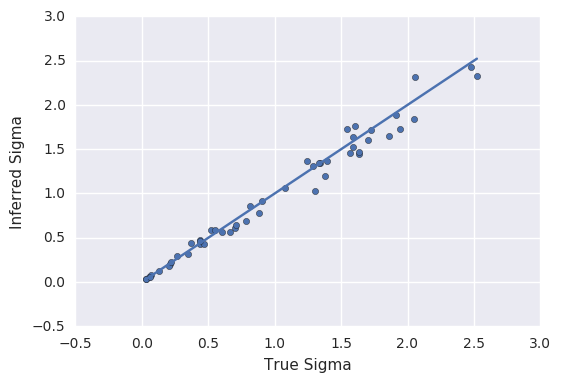

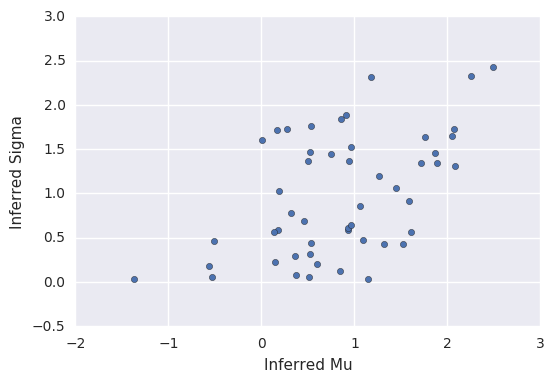

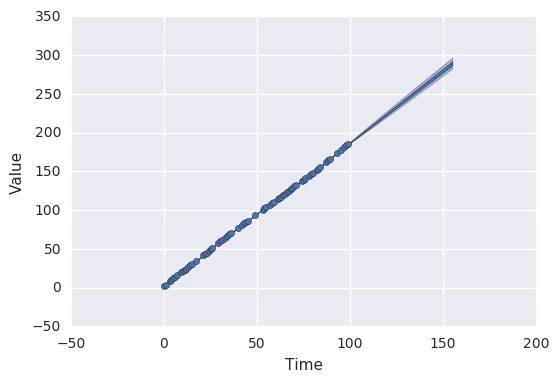

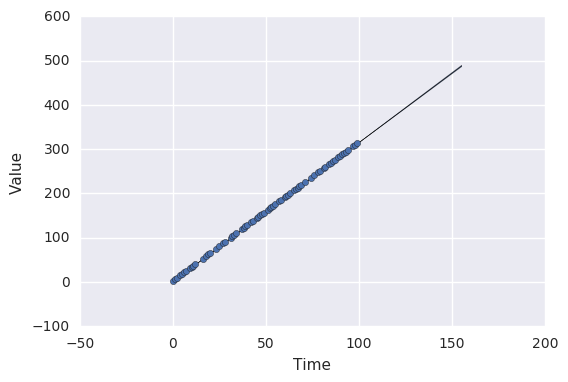

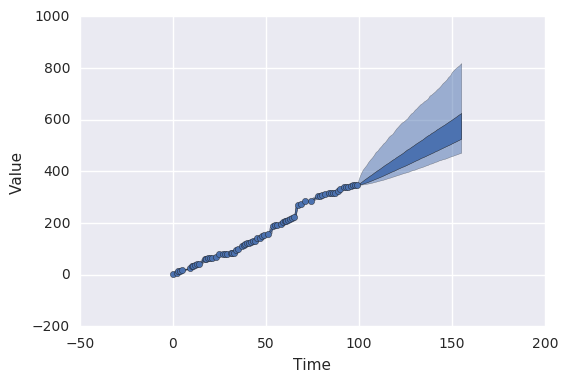

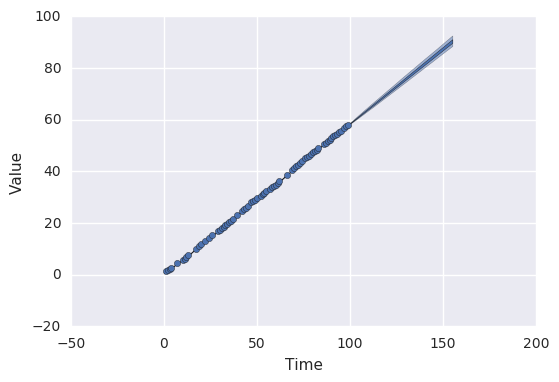

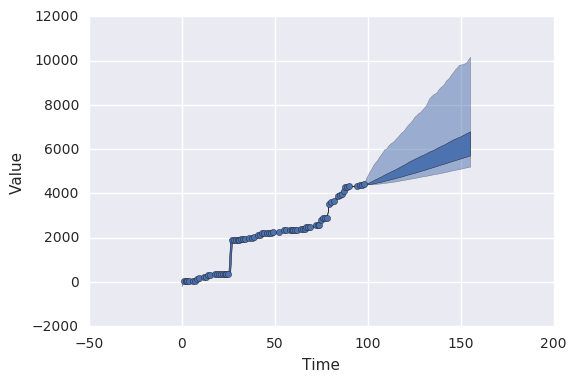

In [40]:
model_name = 'improvement~logN(mu,sigma)'
model_fit = models[model_name]['stan_model'].sampling(data={**stan_data, 
                                                            **models[model_name]['parameter_priors']}, 
                                                      n_jobs=n_jobs)

print("Portion of true mus within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print("Portion of true sigmas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))

print(_print_stanfit(model_fit, ['mu', 'sigma']))


scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
plot(sort(mus),sort(mus))
xlabel("True Mu")
ylabel("Inferred Mu")

figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
plot(sort(sigmas),sort(sigmas))
xlabel("True Sigma")
ylabel("Inferred Sigma")

figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )
xlabel("Inferred Mu")
ylabel("Inferred Sigma")

    
for i in arange(stan_data['N_technologies'])[:5]:
    figure()
    plot_time_series_inference(model_fit,'Y_sim',ind=i)
    scatter(arange(simulated_time_series.shape[0]),
               simulated_time_series[:,i])
    xlabel("Time")
    ylabel("Value")

Portion of true mus within 95% credible interval: 0.92
Portion of true sigmas within 95% credible interval: 0.96
Inferred Omega:
[[ 1.          0.50955111]
 [ 0.50955111  1.        ]]
Inferred Tau:
[ 0.82892495  1.16575418]
Inferred Covariance
[[ 0.69502652  0.50131082]
 [ 0.50131082  1.37409814]]
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        0.6  3.3e-4   0.02   0.56   0.58    0.6   0.61   0.64   4000    1.0
mu[1]       1.14  5.2e-5 3.3e-3   1.14   1.14   1.14   1.14   1.15   4000    1.0
mu[2]       0.54  2.2e-3   0.14   0.25   0.44   0.54   0.63   0.81   4000    1.0
mu[3]      -0.56  3.0e-4   0.02   -0.6  -0.57  -0.56  -0.55  -0.52   4000    1.0
mu[4]       2.08  2.8e-3   0.18   1.73   1.96   2.08    2.2   2.43   4000    1.0
mu[5]       0.98  3.0e-3   0.19    0.6   0.85   0.98    1.1   1.35   4000    1.0
mu[6]       0.36

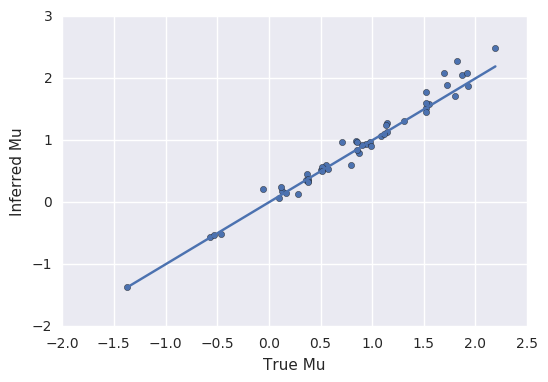

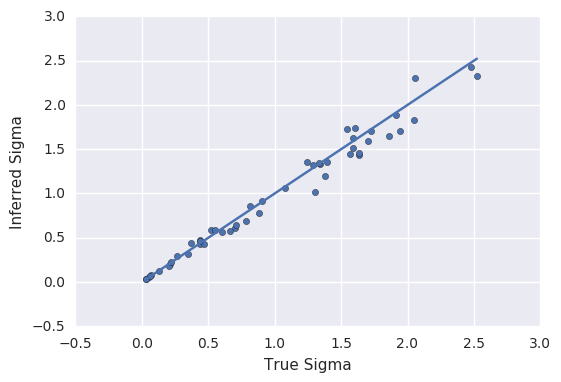

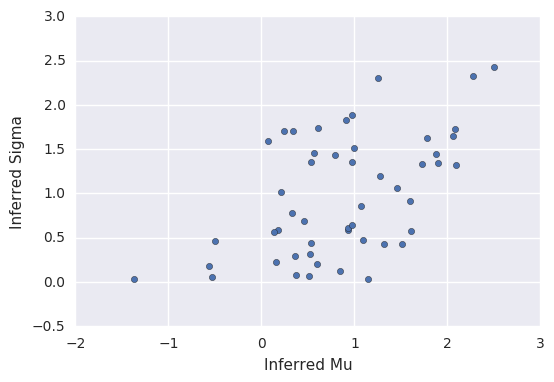

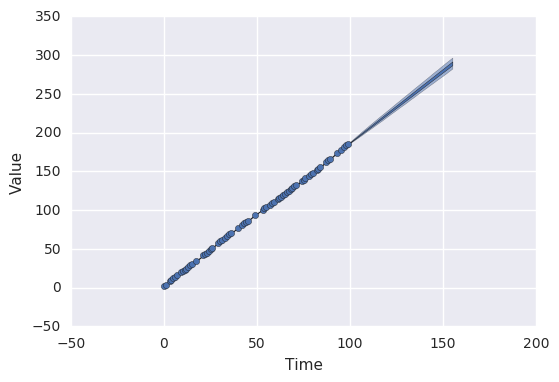

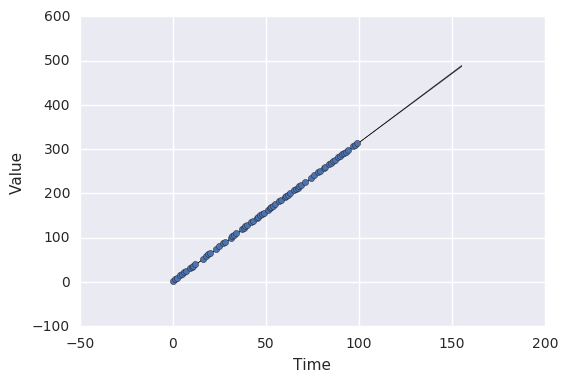

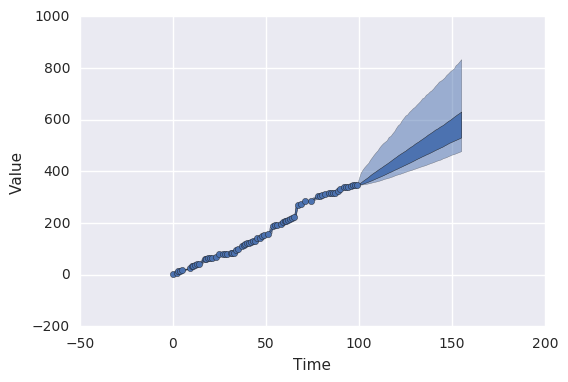

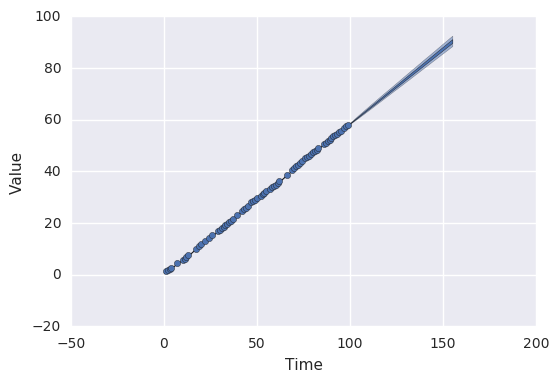

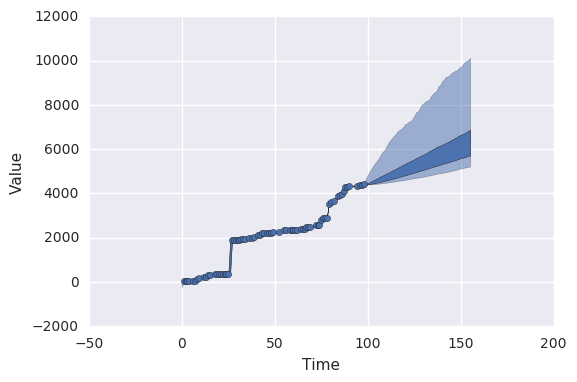

In [41]:
model_name = 'improvement~logN(mu,sigma), hierarchical'
model_fit = models[model_name]['stan_model'].sampling(data={**stan_data, 
                                                            **models[model_name]['parameter_priors']}, 
                                                      n_jobs=n_jobs)

print("Portion of true mus within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print("Portion of true sigmas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))

print("Inferred Omega:")
print(mean(calculate_Omega_from_L_Omega(model_fit),axis=0))

print("Inferred Tau:")
print(model_fit['tau'].mean(axis=0))


print("Inferred Covariance")
print(mean(calculate_covariance_from_L_Omega_and_tau(model_fit),axis=0))

print(_print_stanfit(model_fit, ['mu', 'sigma']))


scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
plot(sort(mus),sort(mus))
xlabel("True Mu")
ylabel("Inferred Mu")

figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
plot(sort(sigmas),sort(sigmas))
xlabel("True Sigma")
ylabel("Inferred Sigma")

figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )
xlabel("Inferred Mu")
ylabel("Inferred Sigma")

    
for i in arange(stan_data['N_technologies'])[:5]:
    figure()
    plot_time_series_inference(model_fit,'Y_sim',ind=i)
    scatter(arange(simulated_time_series.shape[0]),
               simulated_time_series[:,i])
    xlabel("Time")
    ylabel("Value")

### Bernoulli*Normal

In [14]:
model_name = 'improvement~bernoulli(theta)N(mu,sigma)'
models[model_name] = {}
models[model_name]['code'] = base_time_series_program%{
### model
'model': """
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    theta ~ normal(theta_prior_shape_1, theta_prior_shape_2);

    for (tech in 1:N_technologies){
        for (t in tech_starts[tech]:tech_stops[tech]){
            target += log_mix(theta[tech],
                          lower_truncated_normal_lpdf(updates[t] | mu[tech], sigma[tech], 0.0), 
                          lower_truncated_normal_lpdf(updates[t] | 0, 0.01, 0));
        }
    }
""",

### parameters
'parameters': """
    vector<lower = 0>[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;
    vector<lower = 0, upper = 1>[N_technologies] theta;
""",
    
#### priors
'priors':"""
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
    
    real theta_prior_location;
    real theta_prior_scale;
""",

### increase size
'update_size': """
    // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
    // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
    update_size = -1.0;  
    while (update_size<0){
        update_size = bernoulli_rng(theta[tech])*normal_rng(mu[tech],sigma[tech]);
    }
""",

### functions
'functions':"""
    real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
            return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
    }
""",
    
### update bounds (Dictates if updates can only be positive, only negative, or both. Give the empty string for both.)
'update_bounds':"""<lower = 0>""",
'update_raw_bounds':"""<lower = 0, upper = 1>""",
}

models[model_name]['model_parameters'] = ['mu', 'sigma', 'theta']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 3,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    'theta_prior_shape_1': 1,
    'theta_prior_shape_2': 1
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e76dedd61151a7b8e8e5ced5e61d88aa NOW.


In [ ]:
model_name = 'improvement~bernoulli(theta)N(mu,sigma), hierarchical'
models[model_name] = {}
models[model_name]['code'] = base_time_series_program%{
### model
'model': """
    tau ~ cauchy(0, 2);
    L_Omega ~ lkj_corr_cholesky(1);
    mu_mu ~ normal(mu_prior_location, mu_prior_scale);
    mu_sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    mu_theta ~ beta(theta_prior_shape_1, theta_prior_shape_2);

    {
    matrix[N_technologies, 3] parvec;
    vector[3] mu_parvec;
    vector[N_technologies] transformed_theta;
    
    for (tech in 1:N_technologies){
        transformed_theta[tech] = (1+exp(theta[tech]))^-1.0;
    }
    
    parvec = append_col(mu, log(sigma));
    mu_parvec[1] = mu_mu;
    mu_parvec[2] = log(mu_sigma);
    mu_parvec[3] = log(1/mu_theta-1)    
    for (tech in 1:N_technologies){
        parvec[tech] ~ multi_normal_cholesky(mu_parvec, diag_pre_multiply(tau, L_Omega));
    }
    }
    
    for (tech in 1:N_technologies){
        for (t in tech_starts[tech]:tech_stops[tech]){
            target += log_mix(theta[tech],
                          lower_truncated_normal_lpdf(updates[t] | mu[tech], sigma[tech], 0.0), 
                          lower_truncated_normal_lpdf(updates[t] | 0, 0.01, 0));
        }
    }
""",

### parameters
'parameters': """
    vector<lower = 0>[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;
    vector<lower = 0, upper = 1>[N_technologies] theta;
    
    cholesky_factor_corr[3] L_Omega;
    vector<lower = 0>[3] tau;
    
    real<lower = 0> mu_mu;
    real<lower = 0> mu_sigma;
    real<lower = 0, upper = 1> mu_theta;
""",
    
#### priors
'priors':"""
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
    
    real theta_prior_location;
    real theta_prior_scale;
""",

### increase size
'update_size': """
    // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
    // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
    update_size = -1.0;  
    while (update_size<0){
        update_size = bernoulli_rng(theta[tech])*normal_rng(mu[tech],sigma[tech]);
    }
""",

### functions
'functions':"""
    real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
            return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
    }
""",
    
### update bounds (Dictates if updates can only be positive, only negative, or both. Give the empty string for both.)
'update_bounds':"""<lower = 0>""",
'update_raw_bounds':"""<lower = 0, upper = 1>""",
}

models[model_name]['model_parameters'] = ['mu', 'sigma', 'theta']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 3,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    'theta_prior_shape_1': 1,
    'theta_prior_shape_2': 1
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

In [43]:
### Random walk, missing data, positive steps, possibility of no step,
### multiple technologies, mu and sigma are correlated across technologies
mu_mu = .3
mu_sigma = .5

Omega = matrix([[1,.7],
               [.7,1]])
tau = array([1,1])
cov = diag(tau)*Omega*diag(tau)

p_missing = 0
n = 100
N_technologies = 50

mus = zeros(N_technologies)
sigmas = zeros(N_technologies)
thetas = zeros(N_technologies)

simulated_time_series = empty((n, N_technologies))
for i in arange(N_technologies):
    while mus[i]==0:
        mu, sigma = multivariate_normal(array([mu_mu, mu_sigma]), cov=cov).rvs(1)
        if (sigma>0) and (mu>0):
            mus[i] = mu
            sigmas[i] = sigma
    thetas[i] = rand(1)
    a = -mu / sigma
    simulated_data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)*(rand(n)<thetas[i]).astype('int')
    simulated_time_series[:,i] = cumsum(simulated_data)
    missing = rand(n)<p_missing
    simulated_time_series[missing,i]=nan
    
stan_data = stan_data_from_Y(pd.DataFrame(simulated_time_series))

Portion of true mus within 95% credible interval: 0.98
Portion of true sigmas within 95% credible interval: 0.96
Portion of true thetas within 95% credible interval: 0.94
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       2.18  5.3e-3   0.15   1.91    2.1   2.19   2.27   2.42    770    1.0
mu[1]       0.27  3.6e-3   0.17   0.01   0.14   0.26    0.4   0.62   2138    1.0
mu[2]        0.4  5.1e-3   0.23   0.02   0.21   0.39   0.58   0.84   2037    1.0
mu[3]       1.24    0.01   0.58   0.11   0.82    1.3   1.66   2.25   2158    1.0
mu[4]       1.32    0.02   0.64   0.13   0.84   1.35   1.82   2.46   1673    1.0
mu[5]       0.92    0.01   0.49   0.08   0.53   0.93   1.31   1.83   2172    1.0
mu[6]       0.85  3.0e-5 1.9e-3   0.85   0.85   0.85   0.85   0.85   4000    1.0
mu[7]       0.49  6.3e-3   0.34   0.02    0.2   0.43   0.73   1

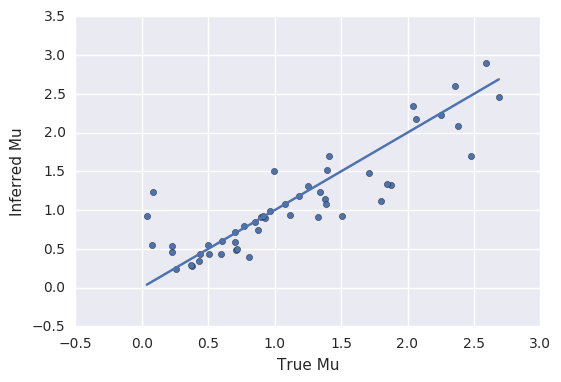

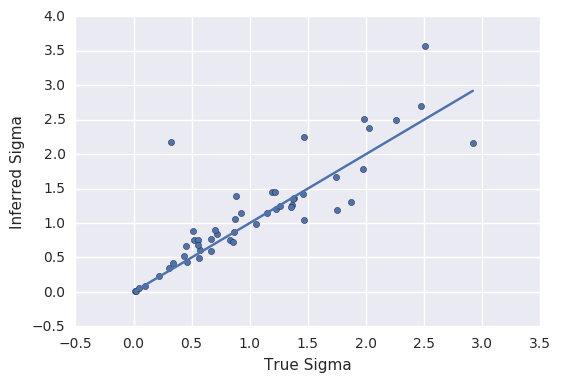

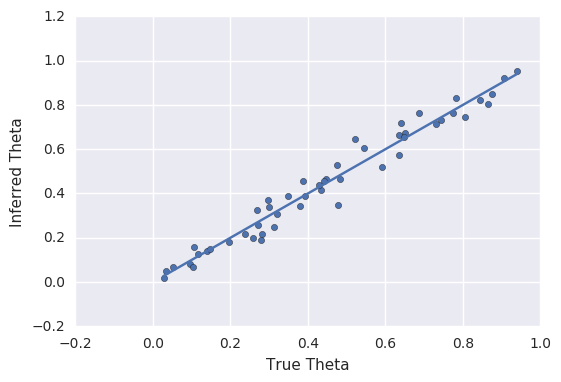

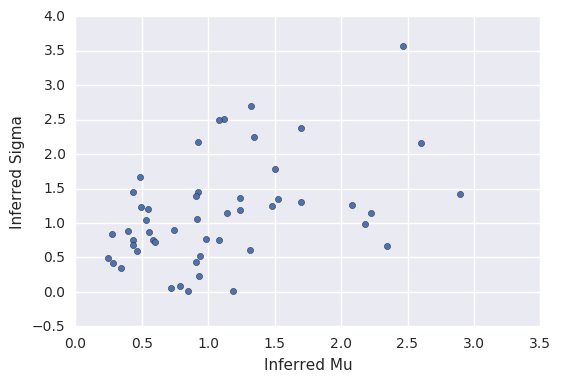

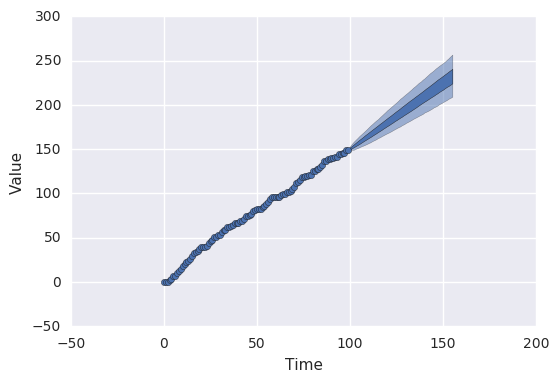

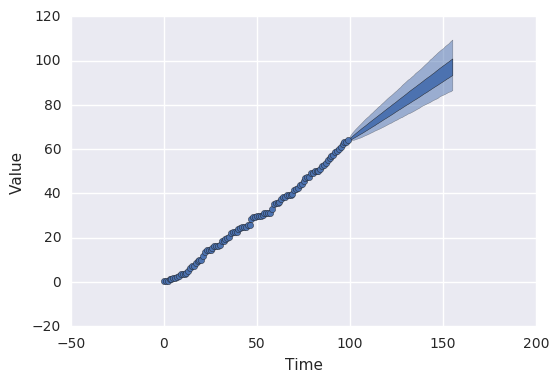

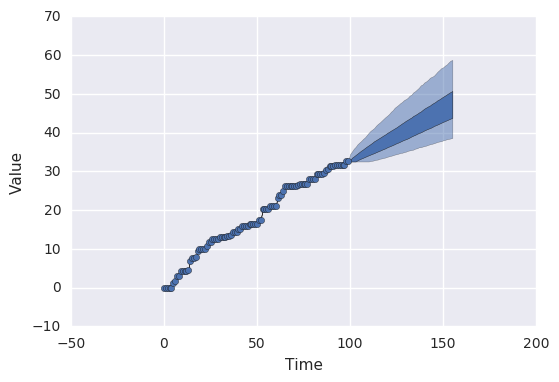

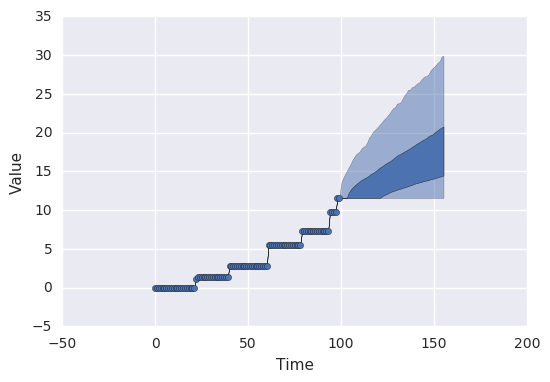

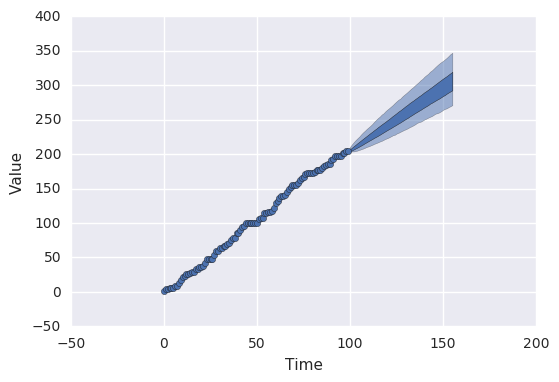

In [44]:
model_name = 'improvement~bernoulli(theta)N(mu,sigma)'
model_fit = models[model_name]['stan_model'].sampling(data={**stan_data, 
                                                            **models[model_name]['parameter_priors']}, 
                                                      n_jobs=n_jobs)


print("Portion of true mus within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print("Portion of true sigmas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))
print("Portion of true thetas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'theta', thetas, 2.5, 97.5))

print(_print_stanfit(model_fit, ['mu', 'sigma', 'theta']))


scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
plot(sort(mus),sort(mus))
xlabel("True Mu")
ylabel("Inferred Mu")

figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
plot(sort(sigmas),sort(sigmas))
xlabel("True Sigma")
ylabel("Inferred Sigma")

figure()
scatter(thetas,
        model_fit['theta'].mean(axis=0)
       )
plot(sort(thetas),sort(thetas))
xlabel("True Theta")
ylabel("Inferred Theta")

figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )
xlabel("Inferred Mu")
ylabel("Inferred Sigma")

    
for i in arange(stan_data['N_technologies'])[:5]:
    figure()
    plot_time_series_inference(model_fit,'Y_sim',ind=i)
    scatter(arange(simulated_time_series.shape[0]),
               simulated_time_series[:,i])
    xlabel("Time")
    ylabel("Value")

In [52]:
with open('model.pkl', 'wb') as f:
    pickle.dump(models, f)

Non-Monotonic Models
====

### Normal

In [16]:
model_name = 'price~N(mu,sigma)'
models[model_name] = {}
models[model_name]['code'] = base_time_series_program%{

### model
'model': """
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

    target += normal_lpdf(updates | mu[updates_tech_inds], sigma[updates_tech_inds]);
""",

### parameters
'parameters': """
    vector[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;
""",
    
#### priors
'priors':"""
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
""",

### increase size
'update_size': """
    // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
    // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
    update_size = normal_rng(mu[tech],sigma[tech]);
""",

### functions
'functions':"""
""",
    
### update bounds (Dictates if updates can only be positive, only negative, or both. Give the empty string for both.)
'update_bounds':"""""",
'update_raw_bounds':"""<lower = -1, upper = 1>""",
}

models[model_name]['model_parameters'] = ['mu', 'sigma']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 3,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a13043215078c070baaa1146201d7ed3 NOW.


In [17]:
model_name = 'price~N(mu,sigma), hierarchical'
models[model_name] = {}
models[model_name]['code'] = base_time_series_program%{

### model
'model': """
    tau ~ cauchy(0, 2);
    L_Omega ~ lkj_corr_cholesky(1);
    mu_mu ~ normal(mu_prior_location, mu_prior_scale);
    mu_sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

    {
    matrix[N_technologies, 2] parvec;
    vector[2] mu_parvec;

    parvec = append_col(mu, log(sigma));
    mu_parvec[1] = mu_mu;
    mu_parvec[2] = log(mu_sigma);
    for (tech in 1:N_technologies){
        parvec[tech] ~ multi_normal_cholesky(mu_parvec, diag_pre_multiply(tau, L_Omega));
    }
    }
    
    target += normal_lpdf(updates | mu[updates_tech_inds], sigma[updates_tech_inds]);
""",
    
### parameters
'parameters': """
    vector[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;

    cholesky_factor_corr[2] L_Omega;
    vector<lower = 0>[2] tau;

    real<lower = 0> mu_mu;
    real<lower = 0> mu_sigma;
""",
    
#### priors
'priors':"""
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
""",

### increase size
'update_size': """
    // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
    // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
        update_size = normal_rng(mu[tech],sigma[tech]);
""",

### functions
'functions':"""
""",

### update bounds (either 0 or 1. Dictates if updates can only be positive, only negative, or both)
'update_bounds':"""""",
'update_raw_bounds':"""<lower = -1, upper = 1>""",

}

models[model_name]['model_parameters'] = ['mu', 'sigma']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 3,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e0a4acf92c9828d1fd3b18ff19256261 NOW.


In [ ]:
### Random walk, missing data multiple technologies, mu and sigma are correlated across technologies

mu_mu = .3
mu_sigma = .5

Omega = matrix([[1,.7],
               [.7,1]])
tau = array([1,1])
cov = diag(tau)*Omega*diag(tau)

p_missing = .2
n = 100
N_technologies = 50

mus = zeros(N_technologies)
sigmas = zeros(N_technologies)
thetas = zeros(N_technologies)

simulated_time_series = empty((n, N_technologies))
for i in arange(N_technologies):
    while mus[i]==0:
        mu, sigma = multivariate_normal(array([mu_mu, mu_sigma]), cov=cov).rvs(1)
        if (sigma>0):# and (mu>0):
            mus[i] = mu
            sigmas[i] = sigma
    thetas[i] = rand(1)
    a = -mu / sigma
    simulated_data = norm(loc=mu,scale=sigma).rvs(n)
    simulated_time_series[:,i] = cumsum(simulated_data)
    missing = rand(n)<p_missing
    simulated_time_series[missing,i]=nan
    
stan_data = stan_data_from_Y(pd.DataFrame(simulated_time_series))

Portion of true mus within 95% credible interval: 0.98
Portion of true sigmas within 95% credible interval: 0.86
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.48  8.3e-3   0.14    0.2   0.39   0.48   0.58   0.76    304   1.02
mu[1]       0.97  7.5e-3   0.14   0.71   0.87   0.96   1.06   1.26    348   1.01
mu[2]       0.37    0.01   0.19-2.0e-3   0.25   0.37    0.5   0.75    367   1.02
mu[3]      -0.23  7.6e-3   0.14   -0.5  -0.32  -0.23  -0.14   0.05    339   1.01
mu[4]       1.12  7.4e-3   0.14   0.85   1.03   1.12   1.22    1.4    367   1.01
mu[5]       0.61  6.1e-3   0.11    0.4   0.54   0.62   0.69   0.81    302   1.03
mu[6]       0.47  6.4e-3   0.11   0.26   0.39   0.47   0.54   0.69    296   1.02
mu[7]      -1.12  1.5e-3   0.03  -1.17  -1.13  -1.12   -1.1  -1.07    280   1.01
mu[8]       0.06  1.8e-3   0.03 3.3e-3  

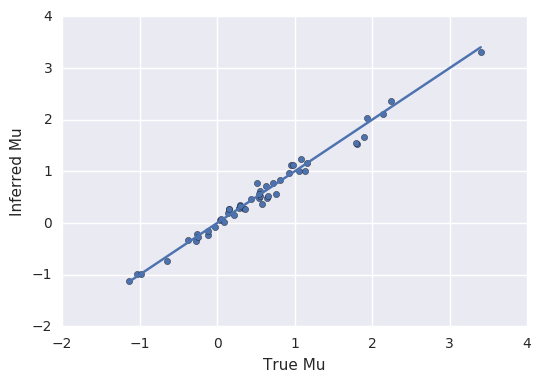

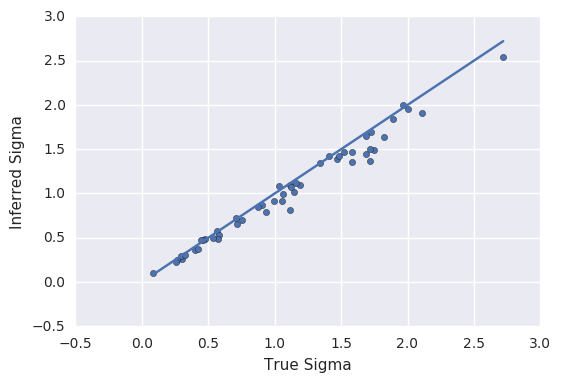

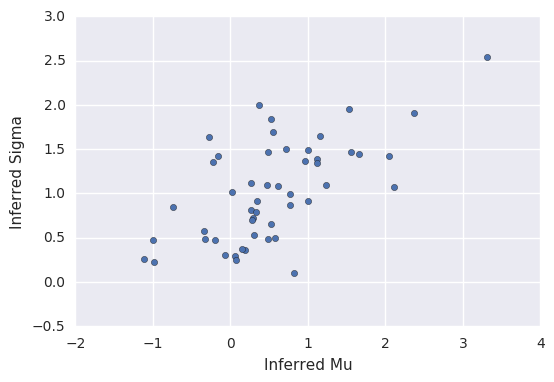

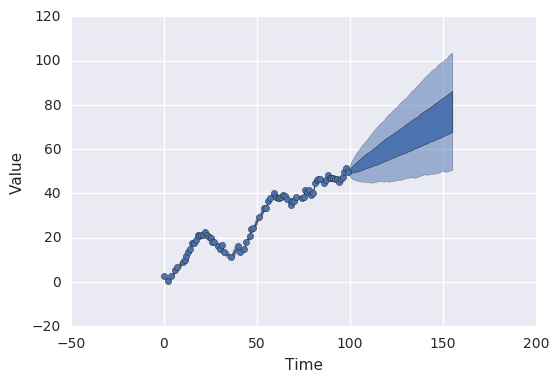

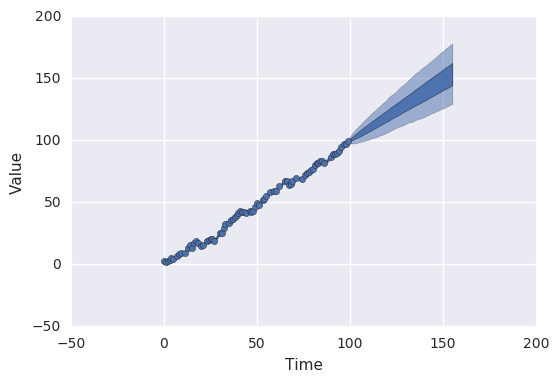

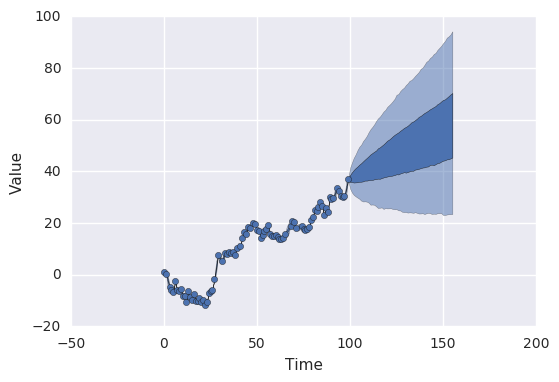

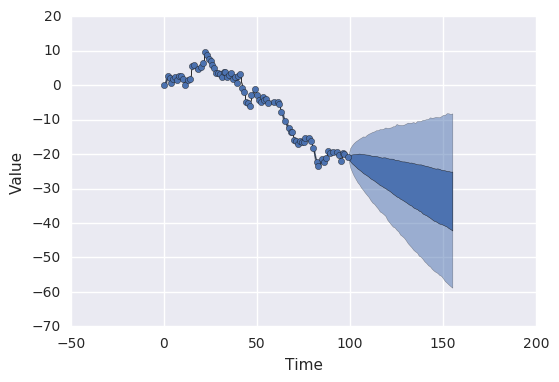

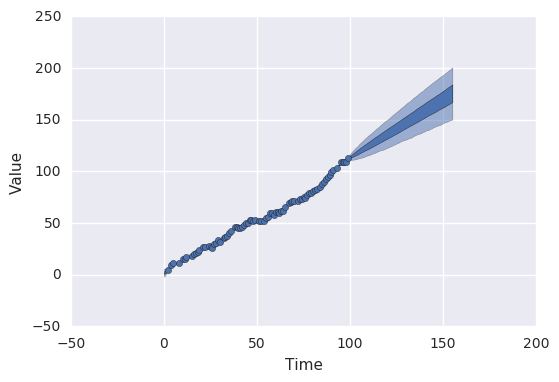

In [24]:
model_name = 'price~N(mu,sigma)'
model_fit = models[model_name]['stan_model'].sampling(data={**stan_data, 
                                                            **models[model_name]['parameter_priors']}, 
                                                      n_jobs=n_jobs)
print("Portion of true mus within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print("Portion of true sigmas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))

print(_print_stanfit(model_fit, ['mu', 'sigma']))


scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
plot(sort(mus),sort(mus))
xlabel("True Mu")
ylabel("Inferred Mu")

figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
plot(sort(sigmas),sort(sigmas))
xlabel("True Sigma")
ylabel("Inferred Sigma")

figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )
xlabel("Inferred Mu")
ylabel("Inferred Sigma")

    
for i in arange(stan_data['N_technologies'])[:5]:
    figure()
    plot_time_series_inference(model_fit,'Y_sim',ind=i)
    scatter(arange(simulated_time_series.shape[0]),
               simulated_time_series[:,i])
    xlabel("Time")
    ylabel("Value")

Portion of true mus within 95% credible interval: 0.98
Portion of true sigmas within 95% credible interval: 0.84
Inferred Omega:
[[ 1.          0.53165846]
 [ 0.53165846  1.        ]]
Inferred Tau:
[ 0.86005297  0.70597905]
Inferred Covariance
[[ 0.74763707  0.3274706 ]
 [ 0.3274706   0.50346022]]
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.49  9.4e-3   0.15    0.2   0.39   0.49   0.59   0.78    240   1.03
mu[1]       0.99  9.3e-3   0.13   0.72    0.9   0.99   1.08   1.25    206   1.02
mu[2]       0.41    0.01   0.19   0.04   0.28   0.41   0.53    0.8    313   1.01
mu[3]      -0.17  6.5e-3   0.13  -0.42  -0.26  -0.17  -0.09   0.08    389    1.0
mu[4]       1.11    0.01   0.14   0.83   1.01   1.11    1.2   1.38    173   1.02
mu[5]       0.63  5.0e-3    0.1   0.44   0.55   0.63    0.7   0.83    404   1.01
mu[6]       0.47

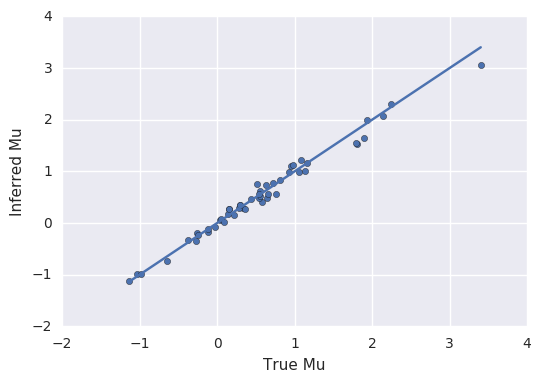

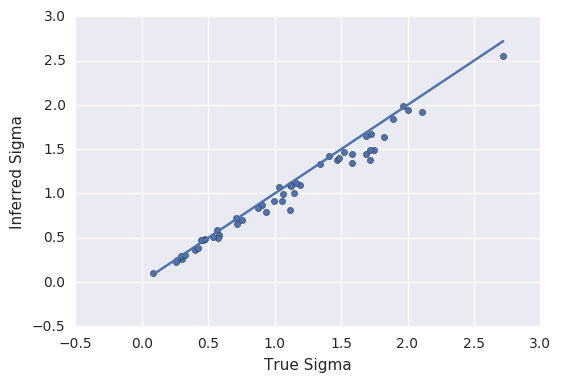

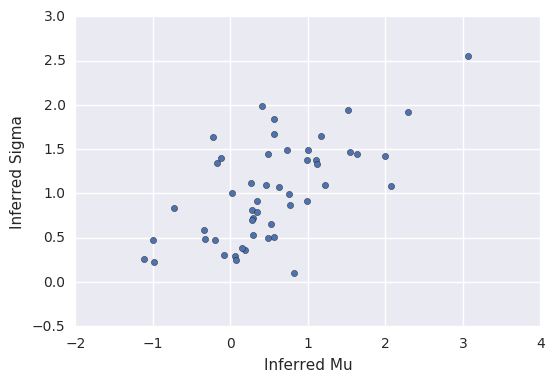

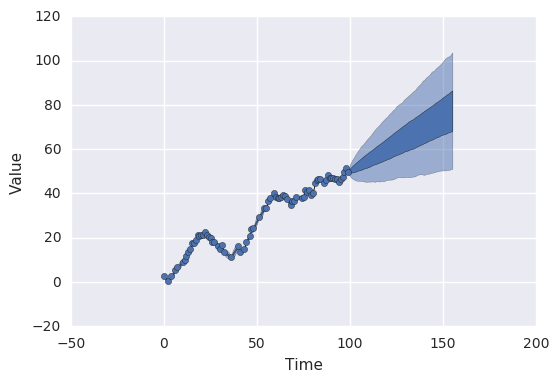

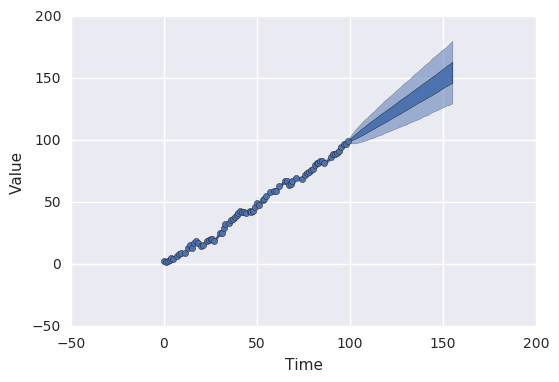

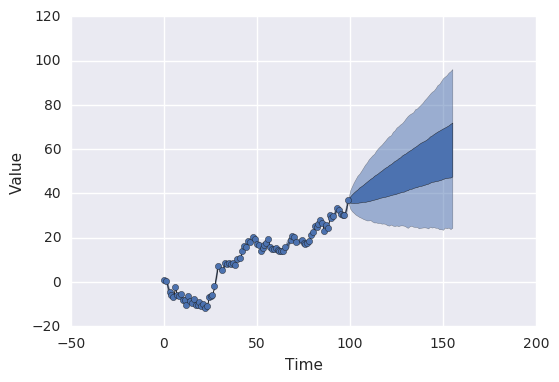

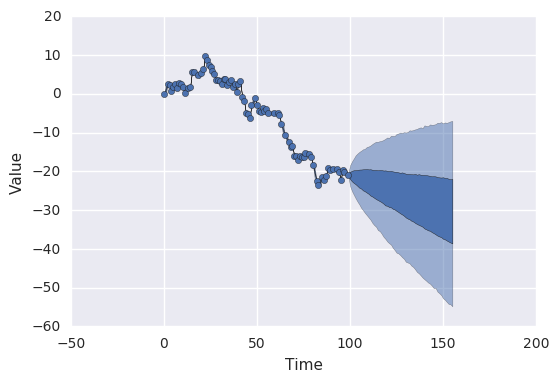

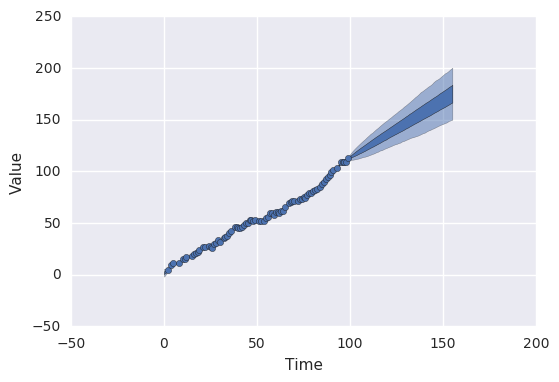

In [29]:
model_name = 'price~N(mu,sigma), hierarchical'
model_fit = models[model_name]['stan_model'].sampling(data={**stan_data, 
                                                            **models[model_name]['parameter_priors']}, 
                                                      n_jobs=n_jobs)

print("Portion of true mus within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print("Portion of true sigmas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))

print("Inferred Omega:")
print(mean(calculate_Omega_from_L_Omega(model_fit),axis=0))

print("Inferred Tau:")
print(model_fit['tau'].mean(axis=0))


print("Inferred Covariance")
print(mean(calculate_covariance_from_L_Omega_and_tau(model_fit),axis=0))

print(_print_stanfit(model_fit, ['mu', 'sigma']))


scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
plot(sort(mus),sort(mus))
xlabel("True Mu")
ylabel("Inferred Mu")

figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
plot(sort(sigmas),sort(sigmas))
xlabel("True Sigma")
ylabel("Inferred Sigma")

figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )
xlabel("Inferred Mu")
ylabel("Inferred Sigma")

    
for i in arange(stan_data['N_technologies'])[:5]:
    figure()
    plot_time_series_inference(model_fit,'Y_sim',ind=i)
    scatter(arange(simulated_time_series.shape[0]),
               simulated_time_series[:,i])
    xlabel("Time")
    ylabel("Value")

### Student's t

In [30]:
model_name = 'price~t(nu,mu,sigma)'
models[model_name] = {}
models[model_name]['code'] = base_time_series_program%{

### model
'model': """
    nu ~ cauchy(nu_prior_location, nu_prior_scale);
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

    target += student_t_lpdf(updates | nu[updates_tech_inds], mu[updates_tech_inds], sigma[updates_tech_inds]);
""",

### parameters
'parameters': """
    vector<lower = 0>[N_technologies] nu;
    vector[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;
""",
    
#### priors
'priors':"""
    real nu_prior_location;
    real nu_prior_scale;
    
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
""",

### increase size
'update_size': """
    // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
    // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
    update_size = student_t_rng(nu[tech], mu[tech],sigma[tech]);
""",

### functions
'functions':"""
""",
    
### update bounds (Dictates if updates can only be positive, only negative, or both. Give the empty string for both.)
'update_bounds':"""""",
'update_raw_bounds':"""<lower = -1, upper = 1>""",
}

models[model_name]['model_parameters'] = ['mu', 'sigma']
models[model_name]['parameter_priors'] = {
    'nu_prior_location': 5,
    'nu_prior_scale': 5,
    'mu_prior_location': 0,
    'mu_prior_scale': 3,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_da36b7875ef8441ea2afbae12925020d NOW.


In [46]:
model_name = 'price~t(nu,mu,sigma), hierarchical'
models[model_name] = {}
models[model_name]['code'] = base_time_series_program%{

### model
'model': """
    tau ~ cauchy(0, 2);
    L_Omega ~ lkj_corr_cholesky(1);
    mu_nu ~ cauchy(nu_prior_location, nu_prior_scale);
    mu_mu ~ normal(mu_prior_location, mu_prior_scale);
    mu_sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

    {
    matrix[N_technologies, 3] parvec;
    vector[3] mu_parvec;

    parvec = append_col(log(nu), append_col(mu, log(sigma)));
    mu_parvec[1] = log(mu_nu);    
    mu_parvec[2] = mu_mu;
    mu_parvec[3] = log(mu_sigma);
    for (tech in 1:N_technologies){
        parvec[tech] ~ multi_normal_cholesky(mu_parvec, diag_pre_multiply(tau, L_Omega));
    }
    }

    nu ~ normal(nu_prior_location, nu_prior_scale);
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

    target += student_t_lpdf(updates | nu[updates_tech_inds], mu[updates_tech_inds], sigma[updates_tech_inds]);
""",

### parameters
'parameters': """
    vector<lower = 0>[N_technologies] nu;
    vector[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;
    
    cholesky_factor_corr[3] L_Omega;
    vector<lower = 0>[3] tau;
    
    real<lower = 0> mu_nu;
    real mu_mu;
    real<lower = 0> mu_sigma;
""",
#### priors
'priors':"""
    real nu_prior_location;
    real nu_prior_scale;
    
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
""",

### increase size
'update_size': """
    // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
    // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
    update_size = student_t_rng(nu[tech], mu[tech],sigma[tech]);
""",

### functions
'functions':"""
""",
    
### update bounds (Dictates if updates can only be positive, only negative, or both. Give the empty string for both.)
'update_bounds':"""""",
'update_raw_bounds':"""<lower = -1, upper = 1>""",
}

models[model_name]['model_parameters'] = ['mu', 'sigma']
models[model_name]['parameter_priors'] = {
    'nu_prior_location': 5,
    'nu_prior_scale': 5,
    'mu_prior_location': 0,
    'mu_prior_scale': 3,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19013ba9a25de4ab325faba7ca5fd460 NOW.


In [44]:
### Random walk with student's t sized steps, missing data multiple technologies, mu and sigma are correlated across technologies
mu_mu = .3
mu_sigma = .5

Omega = matrix([[1,.7],
               [.7,1]])
tau = array([1,1])
cov = diag(tau)*Omega*diag(tau)

p_missing = 0
n = 100
N_technologies = 50

nus = zeros(N_technologies)
mus = zeros(N_technologies)
sigmas = zeros(N_technologies)
thetas = zeros(N_technologies)

simulated_time_series = empty((n, N_technologies))
for i in arange(N_technologies):
    while mus[i]==0:
        mu, sigma = multivariate_normal(array([mu_mu, mu_sigma]), cov=cov).rvs(1)
        if (sigma>0):# and (mu>0):
            mus[i] = mu
            sigmas[i] = sigma
    nus[i] = truncnorm(-5 / 3, 5, 3).rvs(1)
    simulated_data = t(nus[i], loc=mu,scale=sigma).rvs(n)
    simulated_time_series[:,i] = cumsum(simulated_data)
    missing = rand(n)<p_missing
    simulated_time_series[missing,i]=nan
    
stan_data = stan_data_from_Y(pd.DataFrame(simulated_time_series))

Portion of true nus within 95% credible interval: 0.86
Portion of true mus within 95% credible interval: 0.98
Portion of true sigmas within 95% credible interval: 0.84
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
nu[0]     108.68   91.36 2912.2   3.85   6.69   9.38  14.93  91.31   1016    1.0
nu[1]       4.16    0.03   1.69   2.04   3.03   3.82   4.88    8.3   4000    1.0
nu[2]       17.5    1.64  59.94   3.68   6.21   8.64  13.26  71.77   1329    1.0
nu[3]      23.23    2.83 116.37   3.73    6.6   9.64   15.7 104.89   1693    1.0
nu[4]        2.9    0.01   0.88   1.64   2.27   2.74   3.38   4.99   4000    1.0
nu[5]       1.87  6.8e-3   0.43   1.18   1.55   1.82   2.11   2.87   4000    1.0
nu[6]       2.21  9.1e-3   0.57   1.35    1.8   2.13   2.53   3.55   4000    1.0
nu[7]      14.21    0.71  28.06   3.79   6.51   9.02  13.96  50.75

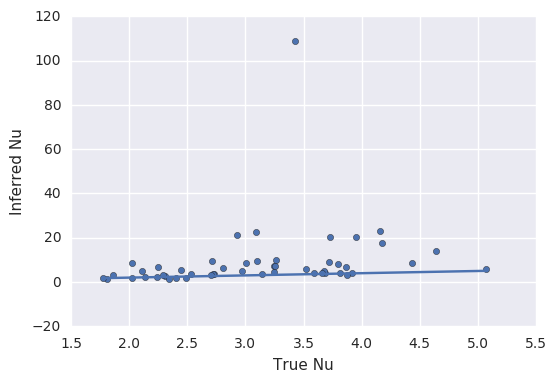

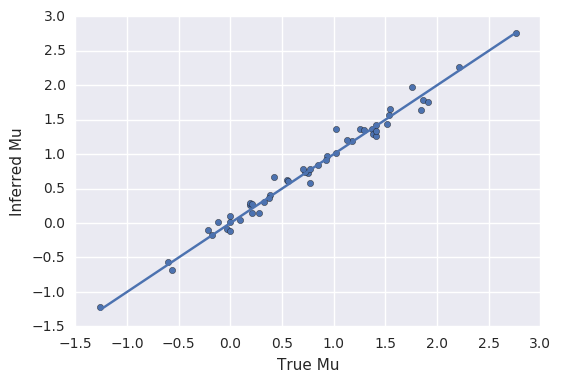

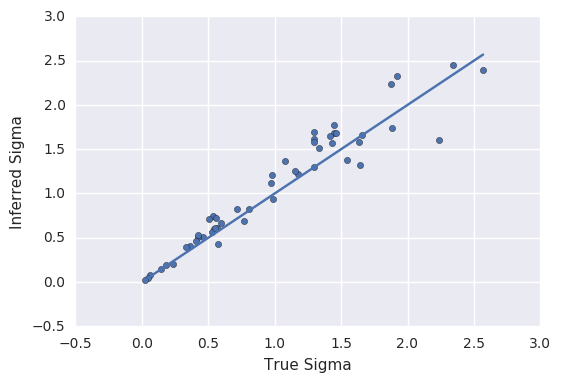

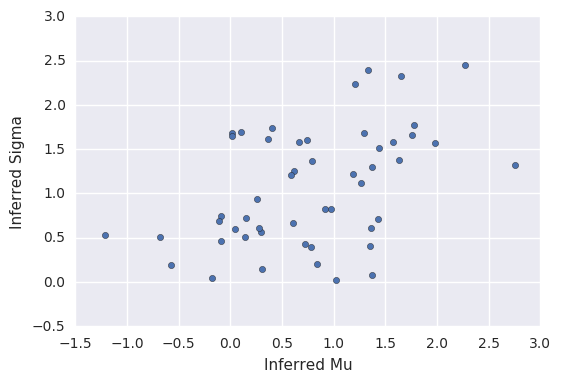

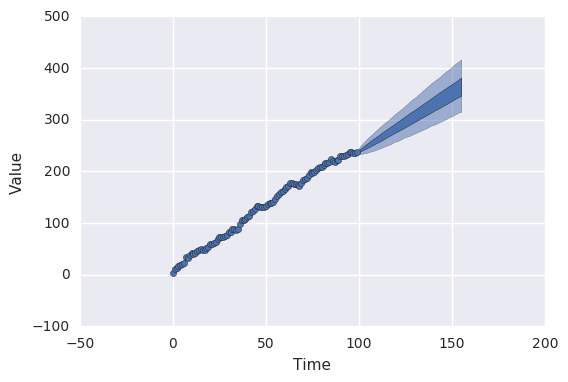

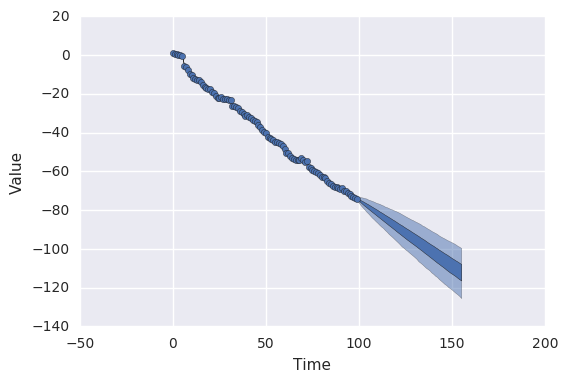

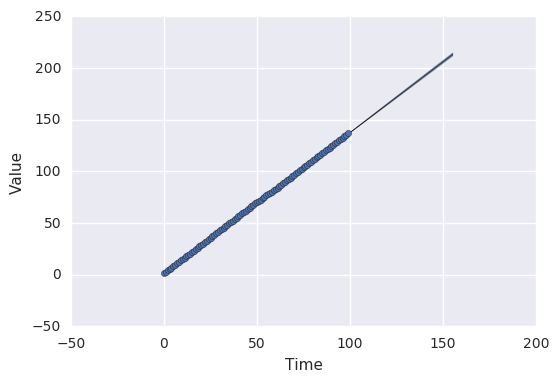

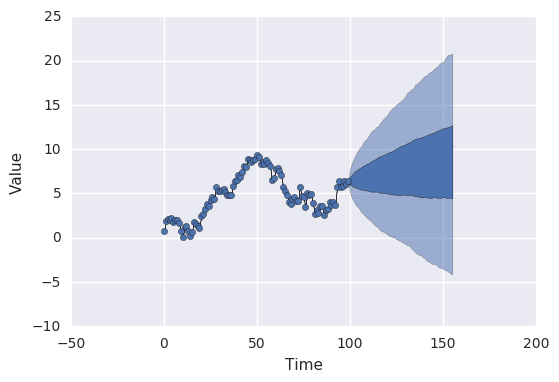

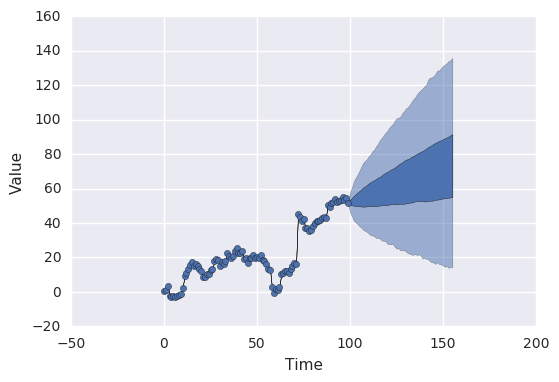

In [45]:
model_name = 'price~t(nu, mu,sigma)'
model_fit = models[model_name]['stan_model'].sampling(data={**stan_data, 
                                                            **models[model_name]['parameter_priors']}, 
                                                      n_jobs=n_jobs)

print("Portion of true nus within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'nu', nus, 2.5, 97.5))
print("Portion of true mus within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print("Portion of true sigmas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))

print(_print_stanfit(model_fit, ['nu', 'mu', 'sigma']))

scatter(nus,
        model_fit['nu'].mean(axis=0)
       )
plot(sort(nus),sort(nus))
xlabel("True Nu")
ylabel("Inferred Nu")

figure()
scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
plot(sort(mus),sort(mus))
xlabel("True Mu")
ylabel("Inferred Mu")

figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
plot(sort(sigmas),sort(sigmas))
xlabel("True Sigma")
ylabel("Inferred Sigma")

figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )
xlabel("Inferred Mu")
ylabel("Inferred Sigma")

    
for i in arange(stan_data['N_technologies'])[:5]:
    figure()
    plot_time_series_inference(model_fit,'Y_sim',ind=i)
    scatter(arange(simulated_time_series.shape[0]),
               simulated_time_series[:,i])
    xlabel("Time")
    ylabel("Value")

Portion of true mus within 95% credible interval: 0.98
Portion of true sigmas within 95% credible interval: 0.90
Inferred Omega:
[[ 1.          0.17535332  0.04820531]
 [ 0.17535332  1.          0.30271287]
 [ 0.04820531  0.30271287  1.        ]]
Inferred Tau:
[ 0.43179895  0.80957929  1.01917841]
Inferred Covariance
[[ 0.19178793  0.06210726  0.0231461 ]
 [ 0.06210726  0.66323856  0.25413802]
 [ 0.0231461   0.25413802  1.05014528]]
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
nu[0]       6.25    0.03   1.98   3.26   4.82   5.96   7.33   10.8   4000    1.0
nu[1]       3.72    0.02   1.07   2.16   2.98   3.56   4.26    6.3   4000    1.0
nu[2]       6.15    0.03   2.06   3.17   4.67   5.81   7.24  11.02   4000    1.0
nu[3]       5.66    0.03   1.88   2.94   4.31   5.33   6.63  10.27   4000    1.0
nu[4]       3.05    0.01   0.75   1.85  

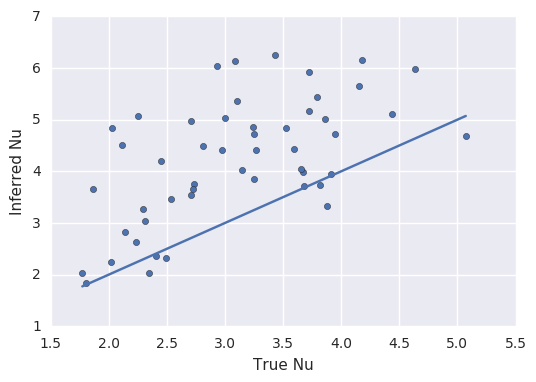

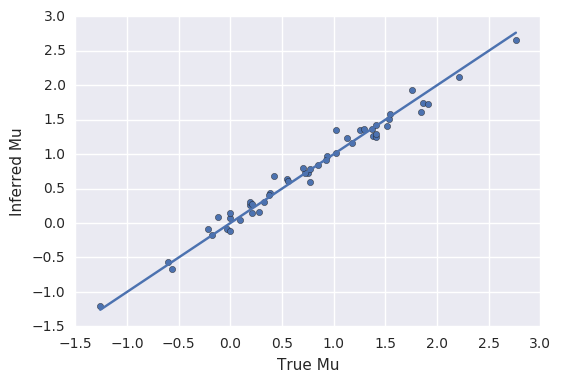

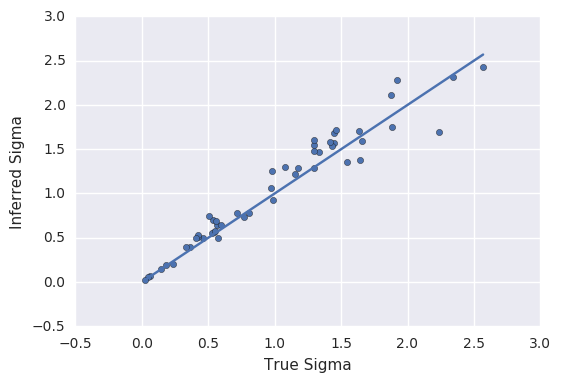

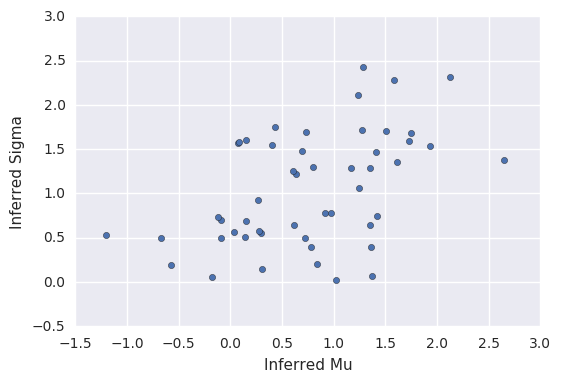

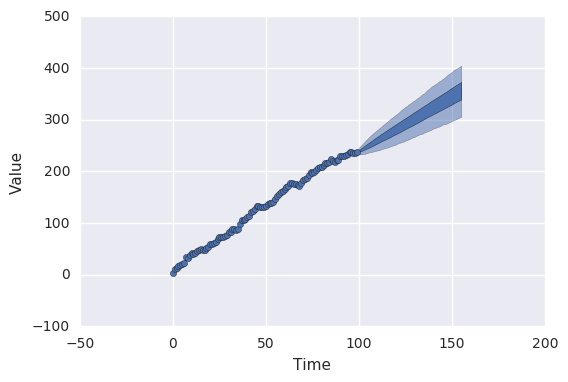

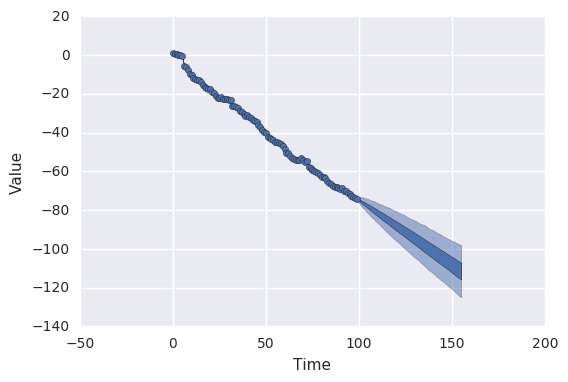

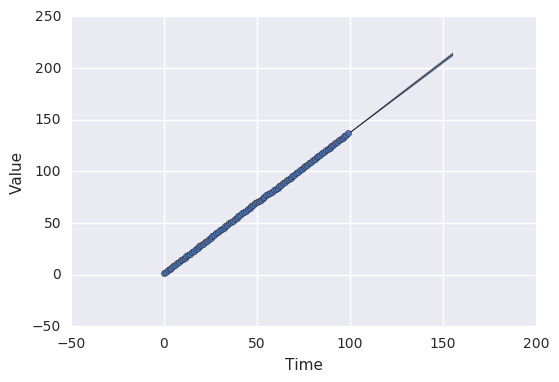

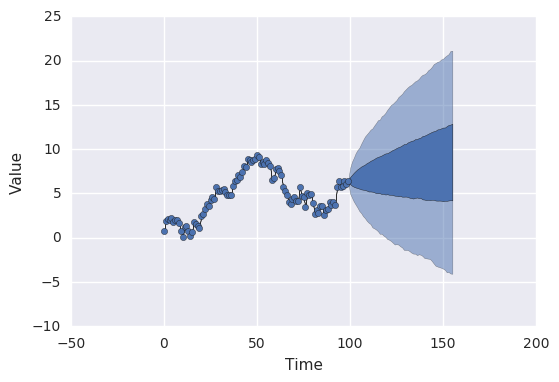

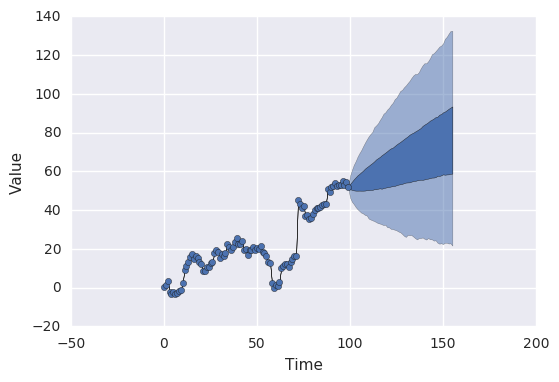

In [55]:
model_name = 'price~t(nu,mu,sigma), hierarchical'
model_fit = models[model_name]['stan_model'].sampling(data={**stan_data, 
                                                            **models[model_name]['parameter_priors']}, 
                                                      n_jobs=n_jobs)

print("Portion of true mus within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print("Portion of true sigmas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))

print("Inferred Omega:")
print(mean(calculate_Omega_from_L_Omega(model_fit),axis=0))

print("Inferred Tau:")
print(model_fit['tau'].mean(axis=0))


print("Inferred Covariance")
print(mean(calculate_covariance_from_L_Omega_and_tau(model_fit),axis=0))

print(_print_stanfit(model_fit, ['nu','mu', 'sigma']))

scatter(nus,
        model_fit['nu'].mean(axis=0)
       )
plot(sort(nus),sort(nus))
xlabel("True Nu")
ylabel("Inferred Nu")


figure()
scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
plot(sort(mus),sort(mus))
xlabel("True Mu")
ylabel("Inferred Mu")

figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
plot(sort(sigmas),sort(sigmas))
xlabel("True Sigma")
ylabel("Inferred Sigma")

figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )
xlabel("Inferred Mu")
ylabel("Inferred Sigma")

    
for i in arange(stan_data['N_technologies'])[:5]:
    figure()
    plot_time_series_inference(model_fit,'Y_sim',ind=i)
    scatter(arange(simulated_time_series.shape[0]),
               simulated_time_series[:,i])
    xlabel("Time")
    ylabel("Value")

Write Models to Disk
====

In [26]:
with open('model.pkl', 'wb') as f:
    pickle.dump(models, f)